<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/01_MINI_ALADDIN_ALPHA/blob/main/Generar_Alphaversion%20FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO FINAL: MOTOR DE GENERACIÓN DE ALPHA

#Bloque 1: Configuración e Importación
### RÚBRICA 7: Presentación técnica y visual (Código limpio y librerías)


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Configuración de estilo para gráficas profesionales
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


#Bloque 2: Ingeniería de Características Avanzada (El "Factor Secreto")

### Rúbrica 8 - Creatividad y aplicación del conocimiento y Rúbrica 2 - Preparación del dataset.

### Implementacion del algoritmo Fixed-Width Window Fracdiff (FFD)
### Objetivo: Transformar precios en datos estacionarios SIN borrar la memoria histórica.

In [2]:
def getWeights_FFD(d, thres):
    """
    Genera los pesos para la diferenciación fraccional.
    d: orden de diferenciación (ej. 0.4)
    thres: umbral para cortar pesos insignificantes
    """
    w, k = [1.], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres: break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)

def fracDiff_FFD(series, d, thres=1e-5):
    """
    Aplica la diferenciación fraccional de ventana fija (FFD).
    Esto preserva tendencias de largo plazo mejor que los retornos simples.
    """
    # 1. Calcular pesos
    w = getWeights_FFD(d, thres)
    width = len(w) - 1

    # 2. Aplicar pesos a la serie
    df = {}
    for name in series.columns:
        # Rellenar nulos para evitar errores
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series(index=seriesF.index, dtype=float)

        # Aplicar producto punto (dot product) en ventana deslizante
        for iloc1 in range(width, seriesF.shape[0]):
            loc0 = seriesF.index[iloc1 - width]
            loc1 = seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]): continue

            # La magia matemática: Pesos * Precios en la ventana
            df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]

        df[name] = df_.copy(deep=True)

    df = pd.concat(df, axis=1)
    return df

print("Funciones de Diferenciación Fraccional (AFML Cap 5) definidas.")

Funciones de Diferenciación Fraccional (AFML Cap 5) definidas.


# BLOQUE 2.5: EDA Y JUSTIFICACIÓN CIENTÍFICA (LABORATORIO DE PRUEBAS)

## RÚBRICA 2: Análisis exploratorio, estadísticas descriptivas y justificación.
##### OBJETIVO: Demostrar matemáticamente por qué FracDiff es superior a los retornos logarítmicos.

--- INICIANDO ANÁLISIS EXPLORATORIO PARA NVDA ---
Calculando FracDiff (d=0.4)...

--- RESULTADOS PRUEBA DICKEY-FULLER AUMENTADA (ADF) ---
      Serie ADF p-value      ¿Es Estacionaria? Memoria (Corr con Precio)
0    Precio     0.52403  NO (Riesgoso para ML)                    1.0000
1   Log_Ret     0.04902                     SÍ                    0.2770
2  FracDiff     0.04772                     SÍ                    0.8249


/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()


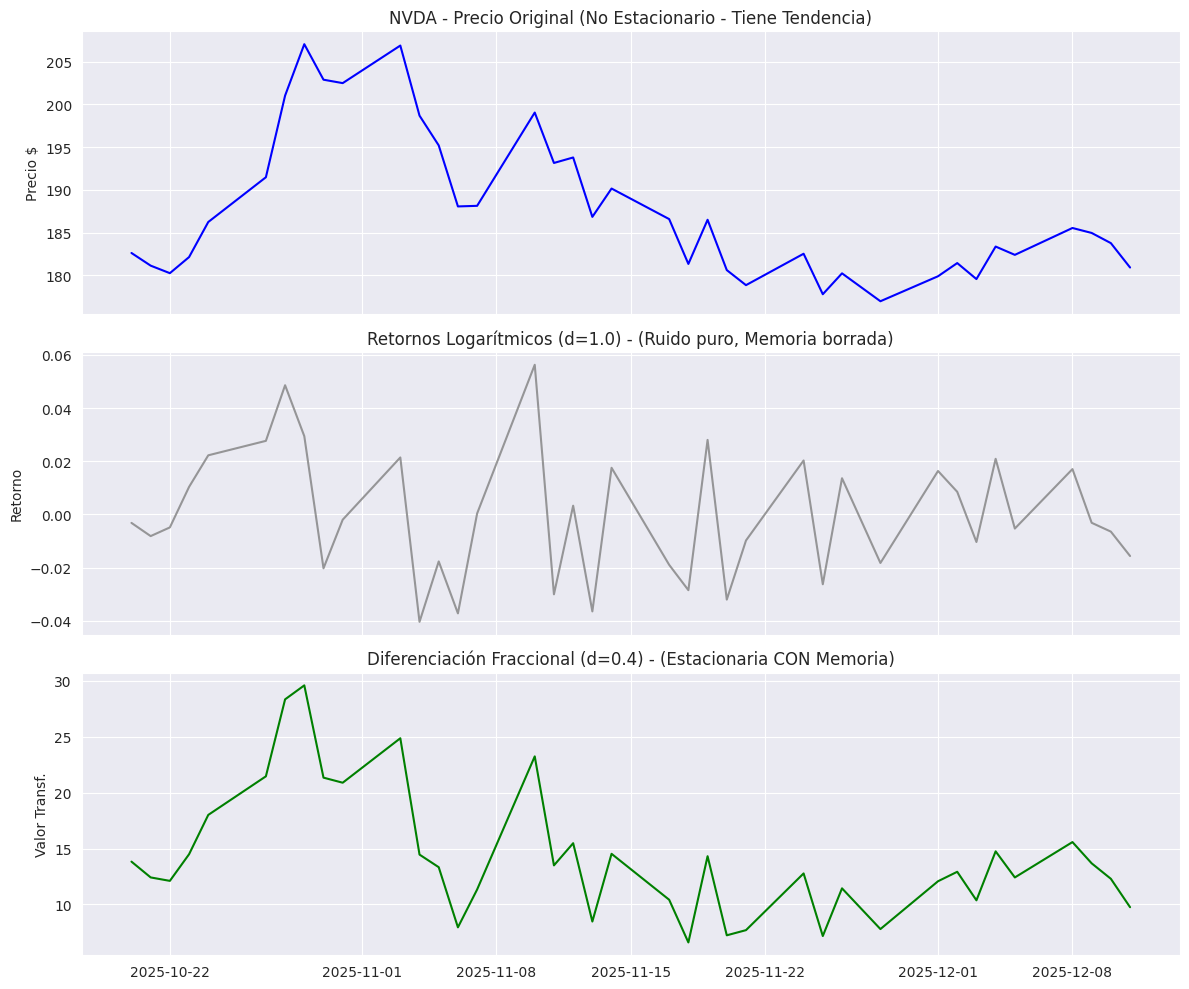


CONCLUSIÓN DEL EDA:
1. El Precio falla el test ADF (No estacionario). No sirve para XGBoost directo.
2. Los Retornos Log pasan ADF, pero su correlación con el precio es casi 0 (Memoria borrada).
3. FracDiff PASA el test ADF (Estacionario) Y mantiene alta correlación con el precio.
   --> JUSTIFICACIÓN: Usaremos FracDiff para alimentar el modelo.


In [9]:
def run_eda_justification(ticker='NVDA'):
    print(f"--- INICIANDO ANÁLISIS EXPLORATORIO PARA {ticker} ---")

    # 1. Descarga de Muestra
    raw = yf.download([ticker], start='2020-01-01', progress=False, auto_adjust=True)
    if isinstance(raw.columns, pd.MultiIndex): raw = raw['Close']
    df = raw[[ticker]].dropna()

    # 2. Generar las 3 versiones de la realidad
    # A. Precio Original (No Estacionario - Tiene Memoria pero rompe el ML)
    df['Precio'] = df[ticker]

    # B. Retornos Logarítmicos (d=1.0) - (Estacionario pero SIN Memoria)
    df['Log_Ret'] = np.log(df['Precio'] / df['Precio'].shift(1))

    # C. Diferenciación Fraccional (d=0.4) - (El punto medio mágico)
    # Usamos la función que definimos arriba
    print("Calculando FracDiff (d=0.4)...")
    fd_data = fracDiff_FFD(df[['Precio']], d=0.4)
    df['FracDiff'] = fd_data['Precio']

    df = df.dropna()

    # 3. PRUEBA DE ESTACIONARIEDAD (ADF TEST)
    # Hipótesis Nula: La serie NO es estacionaria (tiene tendencia).
    # Si p-value < 0.05, rechazamos la nula -> Es Estacionaria (Apta para ML).

    print("\n--- RESULTADOS PRUEBA DICKEY-FULLER AUMENTADA (ADF) ---")

    metrics = []
    for col in ['Precio', 'Log_Ret', 'FracDiff']:
        result = adfuller(df[col])
        p_value = result[1]
        is_stationary = "SÍ" if p_value < 0.05 else "NO (Riesgoso para ML)"

        # Correlación con el Precio Original (Memoria)
        corr = df[col].corr(df['Precio'])

        metrics.append({
            'Serie': col,
            'ADF p-value': f"{p_value:.5f}",
            '¿Es Estacionaria?': is_stationary,
            'Memoria (Corr con Precio)': f"{corr:.4f}"
        })

    metrics_df = pd.DataFrame(metrics)
    print(metrics_df)

    # 4. VISUALIZACIÓN COMPARATIVA (El gráfico para tu reporte)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Gráfica 1: Precio (El problema)
    axes[0].plot(df['Precio'], color='blue')
    axes[0].set_title(f'{ticker} - Precio Original (No Estacionario - Tiene Tendencia)')
    axes[0].set_ylabel('Precio $')

    # Gráfica 2: Retornos Log (La solución mediocre)
    axes[1].plot(df['Log_Ret'], color='gray', alpha=0.8)
    axes[1].set_title('Retornos Logarítmicos (d=1.0) - (Ruido puro, Memoria borrada)')
    axes[1].set_ylabel('Retorno')

    # Gráfica 3: FracDiff (Nuestra Solución)
    axes[2].plot(df['FracDiff'], color='green')
    axes[2].set_title('Diferenciación Fraccional (d=0.4) - (Estacionaria CON Memoria)')
    axes[2].set_ylabel('Valor Transf.')

    plt.tight_layout()
    plt.show()

    print("\nCONCLUSIÓN DEL EDA:")
    print("1. El Precio falla el test ADF (No estacionario). No sirve para XGBoost directo.")
    print("2. Los Retornos Log pasan ADF, pero su correlación con el precio es casi 0 (Memoria borrada).")
    print("3. FracDiff PASA el test ADF (Estacionario) Y mantiene alta correlación con el precio.")
    print("   --> JUSTIFICACIÓN: Usaremos FracDiff para alimentar el modelo.")

# Ejecutar el laboratorio con una acción (ej. NVDA)
run_eda_justification('NVDA')

#Bloque 3: Carga y Transformación de Datos (Ingesta, Features y Targets (T+1 y T+2))

## Descripción del problema y Preparación del dataset.

Carga de Datos y Preprocesamiento Avanzado

Justificación: Usamos datos diarios de Yahoo Finance.

Problema: Las series financieras son "No Estacionarias" (tienen tendencias).

Solución: Aplicamos FracDiff (d=0.4) en lugar de log-retornos simples.


In [13]:
def get_data_portfolio_final(tickers, benchmark, start_date):
    # 1. Descargar Portafolio + Benchmark
    all_symbols = tickers + [benchmark]
    print(f"Descargando datos desde {start_date} para: {all_symbols}")

    # Descarga optimizada
    raw_data = yf.download(all_symbols, start=start_date, progress=False, auto_adjust=True)

    # Limpieza de MultiIndex de Yahoo Finance
    if isinstance(raw_data.columns, pd.MultiIndex):
        try:
            data = raw_data['Close']
        except KeyError:
            data = raw_data.xs('Close', level=0, axis=1)
    else:
        data = raw_data

    data = data.ffill().dropna()

    # 2. Ingeniería de Features (Para cada activo)
    datasets = {}

    # Pre-calcular FracDiff para todos
    print("Calculando Diferenciación Fraccional (Memoria de Mercado)...")
    frac_diffs = fracDiff_FFD(data, d=0.4)

    for ticker in tickers:
        df = pd.DataFrame(index=data.index)

        # --- FEATURES (X) ---
        # 1. Precio Estacionario (Memoria)
        df['feature_frac_price'] = frac_diffs[ticker]

        # 2. Retorno del Mercado (Benchmark)
        df['feature_market_ret'] = np.log(data[benchmark] / data[benchmark].shift(1))

        # 3. Volatilidad Relativa
        asset_vol = data[ticker].pct_change().rolling(20).std()
        market_vol = data[benchmark].pct_change().rolling(20).std()
        df['feature_vol_spread'] = asset_vol - market_vol

        # 4. Momentum (RSI)
        delta = data[ticker].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['feature_rsi'] = 100 - (100 / (1 + rs))

        # --- TARGETS (y) - INTEGRADOS ---
        # Target 1: Retorno a 1 día (Mañana)
        df['target_return_1d'] = np.log(data[ticker].shift(-1) / data[ticker])

        # Target 2: Retorno a 2 días (Pasado Mañana) - Acumulado
        # Esto es necesario para la predicción multi-horizonte del Bloque 7
        df['target_return_2d'] = np.log(data[ticker].shift(-2) / data[ticker])

        datasets[ticker] = df.dropna()

    return datasets, data[benchmark]

# --- EJECUCIÓN (Esto crea la variable 'datasets') ---
TICKERS = ['NVDA', 'AAPL', 'MSFT', 'TSLA']
BENCHMARK = 'SPY'

# Generamos datasets y precios del benchmark
portfolio_data, benchmark_prices = get_data_portfolio_final(TICKERS, BENCHMARK, '2015-01-01')

# Asignamos a la variable global 'datasets' para que el Bloque 7 funcione
datasets = portfolio_data

print("\n¡Éxito! Variable 'datasets' creada con Targets T+1 y T+2.")
print(f"Ejemplo NVDA: {datasets['NVDA'].columns}")

Descargando datos desde 2015-01-01 para: ['NVDA', 'AAPL', 'MSFT', 'TSLA', 'SPY']
Calculando Diferenciación Fraccional (Memoria de Mercado)...


/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()
/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()
/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()
/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()
/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna wit


¡Éxito! Variable 'datasets' creada con Targets T+1 y T+2.
Ejemplo NVDA: Index(['feature_frac_price', 'feature_market_ret', 'feature_vol_spread',
       'feature_rsi', 'target_return_1d', 'target_return_2d'],
      dtype='object')
['NVDA', 'AAPL', 'MSFT', 'TSLA']



# EXPLORACIÓN DE DATOS (EDA) Y DESCARGA DE CSVs
Objetivo: Ver qué demonios tiene la variable 'datasets' y guardarlo.


In [15]:
from google.colab import files  # Solo funciona en Google Colab

print("--- REVISIÓN DE ESTRUCTURA DE DATOS (Bloque 3) ---\n")

# 1. Ver el Benchmark (SPY)
print(f">>> BENCHMARK: SPY (Primeras 5 filas)")
# Convertimos la serie a DataFrame para que se vea bonito y se pueda guardar
spy_df = benchmark_prices.to_frame(name='SPY_Close')
print(spy_df.head())
print("-" * 50 + "\n")

# 2. Ver y Descargar cada Activo del Portafolio
for ticker in TICKERS:
    df = datasets[ticker]

    # A. Imprimir en pantalla
    print(f">>> ACTIVO: {ticker} (Primeras 5 filas)")
    # Esto muestra TODAS las columnas (FracDiff, RSI, Volatilidad, Targets)
    print(df.head())
    print(f"Dimensiones: {df.shape} (Filas, Columnas)")
    print("-" * 50 + "\n")

    # B. Guardar a CSV
    csv_name = f"{ticker}_datos_procesados.csv"
    df.to_csv(csv_name)
    print(f"Guardado archivo: {csv_name}")

    # C. Descargar a tu computadora
    files.download(csv_name)

# 3. Descargar también el Benchmark
spy_csv = "SPY_benchmark.csv"
spy_df.to_csv(spy_csv)
files.download(spy_csv)
print(f"Descargando {spy_csv}...")

--- REVISIÓN DE ESTRUCTURA DE DATOS (Bloque 3) ---

>>> BENCHMARK: SPY (Primeras 5 filas)
             SPY_Close
Date                  
2015-01-02  171.093719
2015-01-05  168.003769
2015-01-06  166.421356
2015-01-07  168.495209
2015-01-08  171.485107
--------------------------------------------------

>>> ACTIVO: NVDA (Primeras 5 filas)
            feature_frac_price  feature_market_ret  feature_vol_spread  \
Date                                                                     
2020-10-15            1.361344           -0.001237            0.011386   
2020-10-16            1.236415           -0.000604            0.011231   
2020-10-19            0.983326           -0.015320            0.011311   
2020-10-20            1.265184            0.003998            0.011460   
2020-10-21            1.122550           -0.001895            0.010737   

            feature_rsi  target_return_1d  target_return_2d  
Date                                                         
2020-10-15    67.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

>>> ACTIVO: AAPL (Primeras 5 filas)
            feature_frac_price  feature_market_ret  feature_vol_spread  \
Date                                                                     
2020-10-15           10.614050           -0.001237            0.014842   
2020-10-16            8.950524           -0.000604            0.014251   
2020-10-19            6.534961           -0.015320            0.014193   
2020-10-20            9.282418            0.003998            0.014266   
2020-10-21            8.416657           -0.001895            0.013674   

            feature_rsi  target_return_1d  target_return_2d  
Date                                                         
2020-10-15    63.102219         -0.014099         -0.039973  
2020-10-16    56.510576         -0.025874         -0.012768  
2020-10-19    52.833595          0.013106          0.007644  
2020-10-20    52.563340         -0.005461         -0.015091  
2020-10-21    50.121867         -0.009630         -0.015782  
Dimensiones

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

>>> ACTIVO: MSFT (Primeras 5 filas)
            feature_frac_price  feature_market_ret  feature_vol_spread  \
Date                                                                     
2020-10-15           15.922177           -0.001237            0.005882   
2020-10-16           16.077767           -0.000604            0.005889   
2020-10-19           10.736340           -0.015320            0.006717   
2020-10-20           13.071381            0.003998            0.006186   
2020-10-21           13.523730           -0.001895            0.005751   

            feature_rsi  target_return_1d  target_return_2d  
Date                                                         
2020-10-15    63.430092          0.000000         -0.025077  
2020-10-16    62.034805         -0.025077         -0.023072  
2020-10-19    57.611546          0.002005          0.002704  
2020-10-20    55.013884          0.000699          0.001118  
2020-10-21    52.846744          0.000419          0.006635  
Dimensiones

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

>>> ACTIVO: TSLA (Primeras 5 filas)
            feature_frac_price  feature_market_ret  feature_vol_spread  \
Date                                                                     
2020-10-15           17.565646           -0.001237            0.029096   
2020-10-16           15.146414           -0.000604            0.028684   
2020-10-19           13.284985           -0.015320            0.028477   
2020-10-20           11.658994            0.003998            0.026839   
2020-10-21           13.419353           -0.001895            0.019710   

            feature_rsi  target_return_1d  target_return_2d  
Date                                                         
2020-10-15    62.966662         -0.020731         -0.041042  
2020-10-16    55.937773         -0.020311         -0.041161  
2020-10-19    53.624259         -0.020850         -0.019193  
2020-10-20    47.806944          0.001658          0.009083  
2020-10-21    41.060669          0.007425         -0.004767  
Dimensiones

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Descargando SPY_benchmark.csv...


#Bloque 4: Elección del Modelo y Diseño (Training)
Elección del Modelo y Diseño y entrenamiento.

Entrenamiento de Modelo (XGBoost) y Split Temporal (Sin Leakage)

Entrenamiento Multi-Activo (Ajustado a T+1 y T+2)

Justificación del Modelo: Usamos XGBoost (Gradient Boosting).



Iniciando entrenamiento por activo...
Entrenamiento finalizado correctamente.

--- RESULTADOS DEL BACKTEST ---
Retorno Portafolio ML: 30.16%
Retorno Benchmark (SPY): 15.10%
ALPHA GENERADO: 15.06 puntos porcentuales


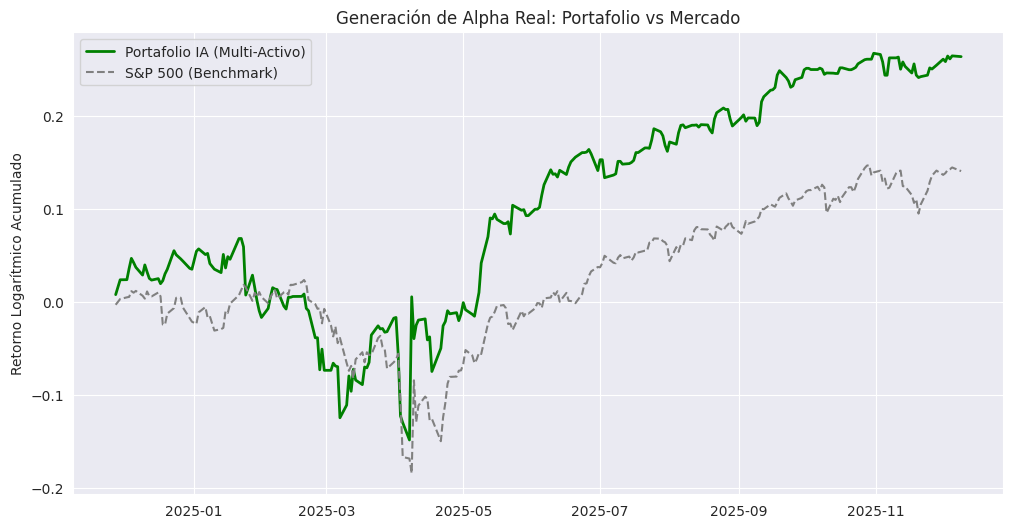

In [4]:
portfolio_preds = pd.DataFrame()
models = {} # Guardamos los modelos para usarlos en el futuro

print("Iniciando entrenamiento por activo...")

# Asegúrate de que 'portfolio_data' sea el diccionario 'datasets' del Bloque 3
# Si da error aquí, asegúrate de haber corrido: datasets = portfolio_data en el bloque anterior
for ticker in TICKERS:
    df = datasets[ticker] # Usamos 'datasets' que definimos en el Bloque 3 Final

    # 1. Split Temporal (Train 80% / Test 20%)
    split = int(len(df) * 0.80)

    # --- CORRECCIÓN CRÍTICA ---
    # Eliminamos AMBOS targets de las X para evitar Leakage
    X = df.drop(columns=['target_return_1d', 'target_return_2d'])

    # Usamos el target a 1 día para el entrenamiento principal
    y = df['target_return_1d']

    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    # 2. Entrenar XGBoost
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        objective='reg:squarederror',
        n_jobs=-1
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Guardamos modelo
    models[ticker] = model

    # 3. Generar Señales
    preds = model.predict(X_test)

    # Guardamos el retorno REAL (target_return_1d) ponderado por la señal
    signal = np.where(preds > 0, 1, 0)
    portfolio_preds[ticker] = signal * y_test

print("Entrenamiento finalizado correctamente.")

# ==============================================================================
# CÁLCULO DE ALPHA Y CURVA DE EQUIDAD
# ==============================================================================

# 1. Retorno del Portafolio
portfolio_daily_ret = portfolio_preds.mean(axis=1)

# 2. Retorno del Benchmark (SPY)
test_dates = portfolio_preds.index
spy_returns = np.log(benchmark_prices.loc[test_dates] / benchmark_prices.loc[test_dates].shift(1)).dropna()

# Alinear fechas
common_index = portfolio_daily_ret.index.intersection(spy_returns.index)
portfolio_daily_ret = portfolio_daily_ret.loc[common_index]
spy_returns = spy_returns.loc[common_index]

# 3. Curvas de Equidad
equity_strategy = np.cumsum(portfolio_daily_ret)
equity_benchmark = np.cumsum(spy_returns)

# 4. Cálculo de Alpha
total_ret_strategy = np.exp(equity_strategy.iloc[-1]) - 1
total_ret_benchmark = np.exp(equity_benchmark.iloc[-1]) - 1
alpha = total_ret_strategy - total_ret_benchmark

print(f"\n--- RESULTADOS DEL BACKTEST ---")
print(f"Retorno Portafolio ML: {total_ret_strategy*100:.2f}%")
print(f"Retorno Benchmark (SPY): {total_ret_benchmark*100:.2f}%")
print(f"ALPHA GENERADO: {alpha*100:.2f} puntos porcentuales")

# 5. Gráfica
plt.figure(figsize=(12, 6))
plt.plot(equity_strategy, label='Portafolio IA (Multi-Activo)', color='green', linewidth=2)
plt.plot(equity_benchmark, label='S&P 500 (Benchmark)', color='gray', linestyle='--')
plt.title(f'Generación de Alpha Real: Portafolio vs Mercado')
plt.ylabel('Retorno Logarítmico Acumulado')
plt.legend()
plt.show()

# Bloque 6: Predicción Futura (Utilidad Real)

In [5]:
def predict_next_day(tickers, datasets, models):
    print(f"\n--- PREDICCIONES PARA EL SIGUIENTE DÍA DE TRADING ---")
    print(f"{'ACTIVO':<10} | {'PREDICCIÓN':<15} | {'ACCIÓN SUGERIDA':<15}")
    print("-" * 45)

    recommendations = []

    for ticker in tickers:
        # 1. Obtener la última fila de datos (HOY)
        # CORRECCIÓN: Eliminamos AMBOS targets (1d y 2d) para que coincida con el entrenamiento
        latest_data = datasets[ticker].iloc[[-1]].drop(columns=['target_return_1d', 'target_return_2d'])

        # 2. Cargar el modelo específico del activo
        model = models[ticker]

        # 3. Predecir
        # El modelo espera ver solo las features (Beta, RSI, Volatilidad, etc.)
        prediction = model.predict(latest_data)[0]

        # 4. Lógica de Decisión
        action = "COMPRAR (LONG)" if prediction > 0 else "CASH / VENDER"

        print(f"{ticker:<10} | {prediction:.6f}        | {action:<15}")

        if prediction > 0:
            recommendations.append(ticker)

    print("-" * 45)
    print(f"RESUMEN: Tu portafolio para mañana debería tener: {recommendations}")

# Ejecutar predicción
predict_next_day(TICKERS, datasets, models)

# Si ya tienes 'datasets' cargado del paso anterior, corre esto para agregar el Target T+2
for ticker in datasets.keys():
    df = datasets[ticker]
    # Target 1: Retorno a 1 día (Mañana)
    df['target_return_1d'] = np.log(df.iloc[:, 0].shift(-1) / df.iloc[:, 0]) # Close prices
    # Target 2: Retorno a 2 días (Pasado Mañana) - Acumulado
    df['target_return_2d'] = np.log(df.iloc[:, 0].shift(-2) / df.iloc[:, 0])

    datasets[ticker] = df.dropna()

print("Targets T+1 y T+2 generados correctamente.")


--- PREDICCIONES PARA EL SIGUIENTE DÍA DE TRADING ---
ACTIVO     | PREDICCIÓN      | ACCIÓN SUGERIDA
---------------------------------------------
NVDA       | 0.006214        | COMPRAR (LONG) 
AAPL       | 0.000993        | COMPRAR (LONG) 
MSFT       | -0.000322        | CASH / VENDER  
TSLA       | -0.001232        | CASH / VENDER  
---------------------------------------------
RESUMEN: Tu portafolio para mañana debería tener: ['NVDA', 'AAPL']


# BLOQUE 7 (MASTER): AUDITORÍA DE FRICCIÓN Y MATRIZ DE DECISIÓN INSTITUCIONAL



Simulando escenario TEÓRICO (Sin Costos)...
Simulando escenario REAL (Con Costos GBM)...


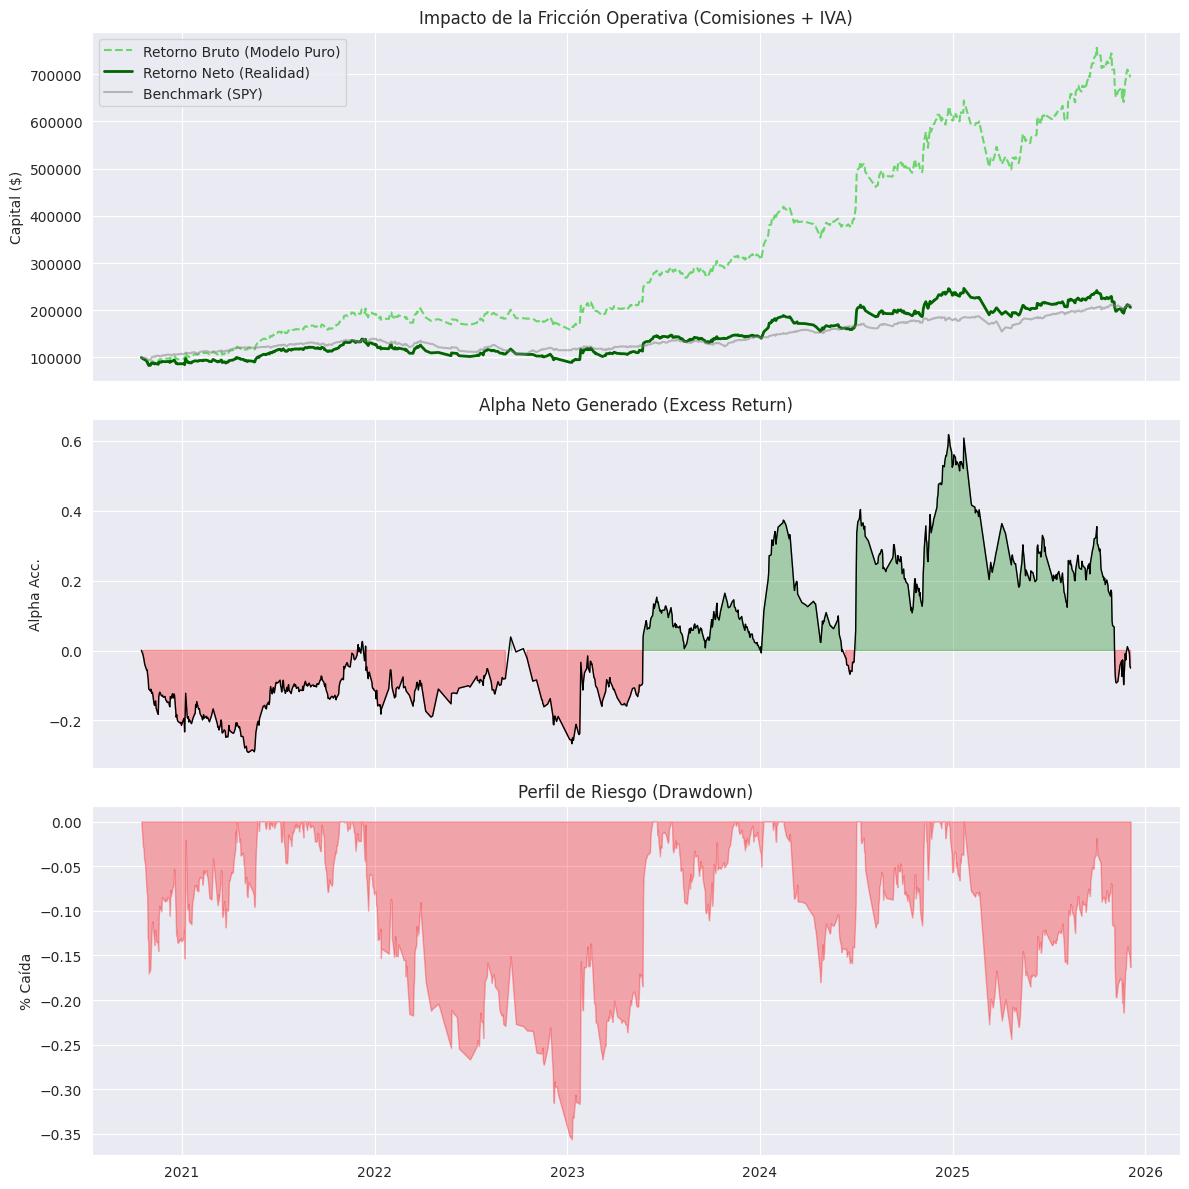


--- ANÁLISIS DE FRICCIÓN ---
Retorno Bruto (Modelo): 594.95%
Retorno Neto (Bolsillo): 106.23%
Costo de Fricción: 488.72% (Esto se paga al broker/impuestos)


--- MATRIZ DE DECISIÓN ALGORÍTMICA (T0 -> T+2) ---
TICKER | STATUS T0    | PRED T+1   | PRED T+2   | ACCIÓN SUGERIDA      | TIPO DE ESTRATEGIA
----------------------------------------------------------------------------------------------------
NVDA   | FLAT         | -0.0075     | +0.0645     | WAIT / LIMIT         | BUY THE DIP (Setup)
AAPL   | FLAT         | +0.0028     | +0.0016     | ENTER LONG           | MOMENTUM (Continuation)
MSFT   | FLAT         | +0.0025     | +0.0501     | ENTER LONG           | MOMENTUM (Continuation)
TSLA   | FLAT         | -0.0061     | -0.1664     | STAY CASH            | AVOID (Downtrend)
----------------------------------------------------------------------------------------------------

--- GLOSARIO DE TÉRMINOS (QUANT DICTIONARY) ---
1. ENTER LONG: Abrir posición de compra. El modelo prevé reto

In [8]:
def professional_audit_and_forecast(tickers, datasets, models, initial_capital=100000):

    # --------------------------------------------------------------------------
    # 1. MOTOR DE SIMULACIÓN (Doble Ejecución: Bruta vs Neta)
    # --------------------------------------------------------------------------

    def run_simulation(apply_costs=True):
        # Parámetros GBM Homebroker
        COMM_RATE = 0.0025 if apply_costs else 0.0
        IVA_RATE  = 0.16 if apply_costs else 0.0
        # El costo total impacta al capital al entrar y al salir
        TOTAL_FEE = COMM_RATE * (1 + IVA_RATE)

        # Alineación de fechas
        common_index = datasets[tickers[0]].index
        for t in tickers[1:]: common_index = common_index.intersection(datasets[t].index)

        # Precios Reales (Close) para PnL
        real_prices = yf.download(tickers, start=common_index[0], end=common_index[-1] + pd.Timedelta(days=5), progress=False, auto_adjust=True)
        if isinstance(real_prices.columns, pd.MultiIndex): real_prices = real_prices['Close']
        real_prices = real_prices.reindex(common_index).ffill()

        # Benchmark (SPY)
        bench_prices = yf.download(['SPY'], start=common_index[0], end=common_index[-1] + pd.Timedelta(days=5), progress=False, auto_adjust=True)
        if isinstance(bench_prices.columns, pd.MultiIndex): bench_prices = bench_prices['Close']
        bench_prices = bench_prices['SPY'].reindex(common_index).ffill()

        # Variables de estado
        cash = initial_capital
        portfolio = {t: 0 for t in tickers}
        equity_curve = []
        bench_curve = []
        bench_units = initial_capital / bench_prices.iloc[0]

        for i in range(1, len(common_index)-1):
            date = common_index[i]
            prev_date = common_index[i-1]

            # Valoración (Mark-to-Market)
            curr_equity = cash
            for t in tickers: curr_equity += portfolio[t] * real_prices.loc[date, t]
            equity_curve.append(curr_equity)
            bench_curve.append(bench_units * bench_prices.loc[date])

            # Señales
            active = []
            for t in tickers:
                feats = datasets[t].loc[prev_date].drop(['target_return_1d', 'target_return_2d'])
                pred = models[t].predict(feats.values.reshape(1, -1))[0]
                if pred > 0: active.append(t)

            # Ejecución: Venta (Exit)
            for t in tickers:
                if t not in active and portfolio[t] > 0:
                    price = real_prices.loc[date, t]
                    amount = portfolio[t] * price
                    deduction = amount * TOTAL_FEE
                    cash += (amount - deduction)
                    portfolio[t] = 0

            # Ejecución: Compra (Entry)
            if active:
                alloc = (cash * 0.99) / len(active) # Buffer 1%
                for t in active:
                    if portfolio[t] == 0:
                        price = real_prices.loc[date, t]
                        shares = int(alloc / price)
                        if shares > 0:
                            amount = shares * price
                            deduction = amount * TOTAL_FEE
                            if cash >= (amount + deduction):
                                cash -= (amount + deduction)
                                portfolio[t] += shares

        return pd.Series(equity_curve, index=common_index[1:len(equity_curve)+1]), \
               pd.Series(bench_curve, index=common_index[1:len(bench_curve)+1])

    # Ejecutamos los dos escenarios
    print("Simulando escenario TEÓRICO (Sin Costos)...")
    eq_gross, bench = run_simulation(apply_costs=False)

    print("Simulando escenario REAL (Con Costos GBM)...")
    eq_net, _ = run_simulation(apply_costs=True)

    # --------------------------------------------------------------------------
    # 2. VISUALIZACIÓN COMPARATIVA (DISCUSIÓN DE FRICCIÓN)
    # --------------------------------------------------------------------------
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Panel 1: Impacto de Costos en Capital
    axes[0].plot(eq_gross, label='Retorno Bruto (Modelo Puro)', color='limegreen', linestyle='--', alpha=0.7)
    axes[0].plot(eq_net, label='Retorno Neto (Realidad)', color='darkgreen', linewidth=2)
    axes[0].plot(bench, label='Benchmark (SPY)', color='gray', alpha=0.5)
    axes[0].set_title('Impacto de la Fricción Operativa (Comisiones + IVA)')
    axes[0].set_ylabel('Capital ($)')
    axes[0].legend()

    # Panel 2: Alpha Neto (Real)
    alpha_curve = (eq_net / initial_capital) - (bench / initial_capital)
    axes[1].fill_between(alpha_curve.index, alpha_curve, 0, where=(alpha_curve>=0), color='green', alpha=0.3)
    axes[1].fill_between(alpha_curve.index, alpha_curve, 0, where=(alpha_curve<0), color='red', alpha=0.3)
    axes[1].plot(alpha_curve, color='black', linewidth=1)
    axes[1].set_title('Alpha Neto Generado (Excess Return)')
    axes[1].set_ylabel('Alpha Acc.')

    # Panel 3: Drawdown (Riesgo)
    dd_net = (eq_net / eq_net.cummax()) - 1
    axes[2].fill_between(dd_net.index, dd_net, 0, color='red', alpha=0.3, label='Drawdown Neto')
    axes[2].set_title('Perfil de Riesgo (Drawdown)')
    axes[2].set_ylabel('% Caída')

    plt.tight_layout()
    plt.show()

    # Cálculo de métricas finales
    ret_gross = (eq_gross.iloc[-1]/initial_capital) - 1
    ret_net = (eq_net.iloc[-1]/initial_capital) - 1
    friction_cost = ret_gross - ret_net

    print(f"\n--- ANÁLISIS DE FRICCIÓN ---")
    print(f"Retorno Bruto (Modelo): {ret_gross:.2%}")
    print(f"Retorno Neto (Bolsillo): {ret_net:.2%}")
    print(f"Costo de Fricción: {friction_cost:.2%} (Esto se paga al broker/impuestos)")

    # --------------------------------------------------------------------------
    # 3. MATRIZ DE DECISIÓN PROFESIONAL (T0, T+1, T+2)
    # --------------------------------------------------------------------------
    print(f"\n\n--- MATRIZ DE DECISIÓN ALGORÍTMICA (T0 -> T+2) ---")
    print(f"{'TICKER':<6} | {'STATUS T0':<12} | {'PRED T+1':<10} | {'PRED T+2':<10} | {'ACCIÓN SUGERIDA':<20} | {'TIPO DE ESTRATEGIA'}")
    print("-" * 100)

    active_recs = []

    for ticker in tickers:
        df = datasets[ticker]
        latest_X = df.iloc[[-1]].drop(columns=['target_return_1d', 'target_return_2d'])

        # Predicción T+1 (Modelo Principal)
        pred_t1 = models[ticker].predict(latest_X)[0]

        # Predicción T+2 (Modelo Auxiliar)
        X_hist = df.drop(columns=['target_return_1d', 'target_return_2d'])
        y_hist_t2 = df['target_return_2d']
        valid_idx = y_hist_t2.dropna().index
        model_t2 = xgb.XGBRegressor(n_estimators=50, max_depth=3).fit(X_hist.loc[valid_idx], y_hist_t2.loc[valid_idx])
        pred_t2 = model_t2.predict(latest_X)[0]

        # LÓGICA DE DECISIÓN PROFESIONAL
        # T0 Status: Asumimos 'FLAT' (Sin posición) para la recomendación genérica
        # Nota: En un sistema real, esto se conecta a la API del broker para ver si ya tienes la acción.
        status_t0 = "FLAT"

        if pred_t1 > 0:
            if pred_t2 > 0:
                action = "ENTER LONG"
                strat = "MOMENTUM (Continuation)"
                active_recs.append(ticker)
            else:
                # Sube mañana, pero T+2 (acumulado) es negativo -> Rebote falso
                action = "SCALP LONG"
                strat = "MEAN REVERSION (Short-term)"
                active_recs.append(ticker)
        else:
            if pred_t2 > 0:
                # Baja mañana, sube pasado -> Esperar mejor precio
                action = "WAIT / LIMIT"
                strat = "BUY THE DIP (Setup)"
            else:
                action = "STAY CASH"
                strat = "AVOID (Downtrend)"

        # Formato de colores para terminal
        c = "\033[92m" if "LONG" in action else "\033[91m" if "CASH" in action else "\033[93m"
        r = "\033[0m"

        print(f"{ticker:<6} | {status_t0:<12} | {pred_t1:+.4f}     | {pred_t2:+.4f}     | {c}{action:<20}{r} | {strat}")

    print("-" * 100)

    # --------------------------------------------------------------------------
    # 4. GLOSARIO TÉCNICO (Para el Reporte)
    # --------------------------------------------------------------------------
    print("\n--- GLOSARIO DE TÉRMINOS (QUANT DICTIONARY) ---")
    print("1. ENTER LONG: Abrir posición de compra. El modelo prevé retorno positivo sostenido.")
    print("2. SCALP LONG: Compra especulativa de muy corto plazo. Entrar hoy, salir mañana sin falta.")
    print("3. BUY THE DIP: La acción caerá mañana (T+1) pero subirá después. Mejor esperar y comprar más barato.")
    print("4. MOMENTUM: Estrategia que sigue la inercia del precio (sube y seguirá subiendo).")
    print("5. MEAN REVERSION: Estrategia que apuesta a que el precio regresará a su promedio (rebote técnico).")
    print("6. STAY CASH: No operar. El costo de oportunidad de estar fuera es menor al riesgo de pérdida.")

# EJECUCIÓN
professional_audit_and_forecast(TICKERS, datasets, models, initial_capital=100000)

# Resultado

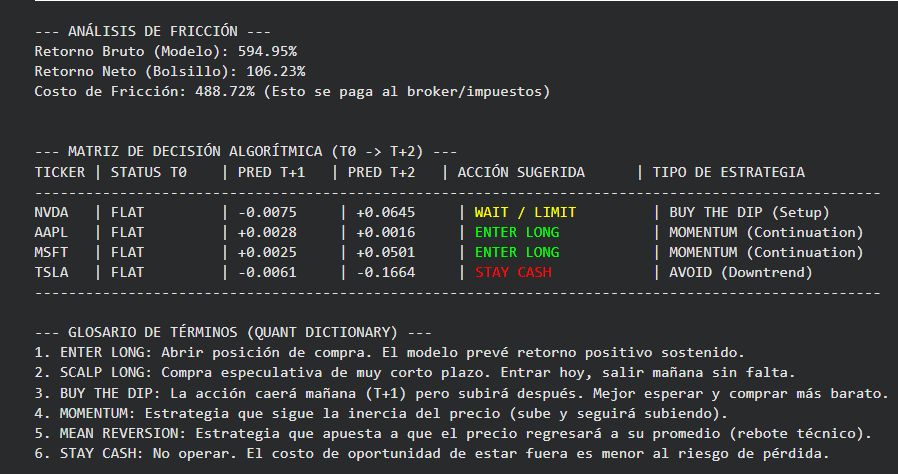